## Changing the current working directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Image Captioning

/content/drive/MyDrive/Image Captioning


## Importing the libraries

In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

import keras
import tensorflow as tf

## Importing the Pre-trained Model

I am using the Xception model to extract the features from images. The last layer of the Xceptionin not included in the final model since I need the features of images rather than classification

In [4]:

xception_model = tf.keras.applications.Xception(
    include_top=True,
    #input_tensor=None,
    #input_shape=None,
    #pooling=None,
    #classes=1000,
    #classifier_activation="softmax",
)

# restructure the model
xception_model = Model(inputs=xception_model.inputs, outputs=xception_model.layers[-2].output)
# summarize
print(xception_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

## Extracting the features from each image using the Xception model

In [5]:
# extract features from image
image_features = {}
directory = 'Images'

for image_name in tqdm(os.listdir(directory)[:4000]):
    # load the image from file
    image_path = directory + '/' + image_name
    image = load_img(image_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = xception_model.predict(image, verbose=0)
    # get image ID
    image_id = image_name.split('.')[0]
    # store feature
    image_features[image_id] = feature

  0%|          | 0/4000 [00:00<?, ?it/s]

The extracted features are saved in a pickle file so that I don't have to extract features each time I run the Jupyter notebook

### saving the extracted features

In [6]:
# store features in pickle
pickle.dump(image_features, open('images_features.pkl', 'wb'))

### loading the extracted features 

**bold text**### loading the extracted featues and all the captions

In [7]:
# load features from pickle
with open( 'images_features.pkl', 'rb') as f:
    features = pickle.load(f)

with open( 'captions.txt', 'r') as f:
    next(f)
    images_captions = f.read()

### mapping the captions to the image id

The captions are loaded from the text file and then each caption is mapped to its correspoding picture. A list is created to keep track if this mapping.

In [8]:
keys = list(features.keys())

In [9]:
# create mapping of image to captions
image_mapping = {}
# process lines
for line in tqdm(images_captions.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    if image_id in keys:
      caption = " ".join(caption)
      # create list if needed
      if image_id not in image_mapping:
        image_mapping[image_id] = []
      # store the caption
      image_mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

### cleaning the captions, removing the unnecessary words

In case the captions contain special characters like !, @, #, $ which may hinder the performance of model I have decide to remove them from captions. The captions only contain upper and lowercase alphabets and spaces.

In [10]:
def process_text(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# preprocess the text
process_text(image_mapping)

### combining all the captions

In [12]:
all_captions = []
for key in image_mapping:
    for caption in image_mapping[key]:
        all_captions.append(caption)

In [13]:
len(all_captions)

20000

## Tokenizing all the captions and finding the vocubolary size

In [14]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)

### Spliting the training and testing samples

For testing and validation purposes I am spliting the dataset in two parts. The training dataset consists of 90% data while the testing data consists of 10% data.

In [15]:
image_ids = list(image_mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

### data loader for the model training in batches

Since I have a lot if images, training them all at once may cause the system to run out of memory consequently casuing the program to crash. For this purpose a function for creating a data loader with batches has been created.

In [16]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Defining the LSTM model for the Image Captioning 

For processing the captions an LSTM model has been created. The encoders image feature processing part takes an input shape of 4096 and is followed by a dropout layer and two dense layers while the sequence feature consists of an embedding layer, dropout layer and finally an LSTM layer.

The decoder is made up of just three dense layers with ReLu activation function.

In [17]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe3 = Dense(256, activation='relu')(fe2)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe3, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 30, 256)      1597440     ['input_3[0][0]']                
                                                                                            

## Training the model

In [19]:
(features[train[0]][0]).shape

(2048,)

The model is being trained with 30 epochs and a batch size of 32.

In [20]:
# train the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, image_mapping, features, tokenizer, max_length, vocab_size, batch_size)

    #valid_generator_data = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size=400)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #loss = model.evaluate_generator(valid_generator_data)

    #print("Validation loss for epoch %s was %s" % (i, loss))

112/112 [==============================] - 23s 204ms/step - loss: 2.5496


### saving the model

In [21]:
model.save('image-captioning-model.h5')

### loading the model

In [22]:
model = keras.models.load_model('image-captioning-model.h5')

### functions for predicting the captions for the image

In [23]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [24]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("", "Images/", image_name)
    image = Image.open(img_path)
    captions = image_mapping[image_id]
  
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("Captions: ")
    print(y_pred)
    plt.imshow(image)

Captions: 
startseq two dogs are playing in the snow endseq


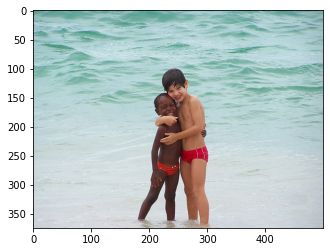

In [26]:
generate_caption(f'{test[250]}.jpg')

Captions: 
startseq two dogs are playing in the snow endseq


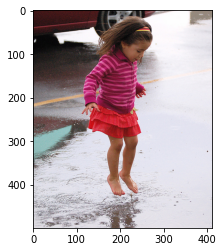

In [27]:
generate_caption(f'{test[50]}.jpg')

Captions: 
startseq man in butchers cap is standing in front of gyro meat endseq


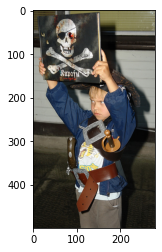

In [28]:
generate_caption(f'{test[100]}.jpg')

Captions: 
startseq two dogs are playing together in the grass endseq


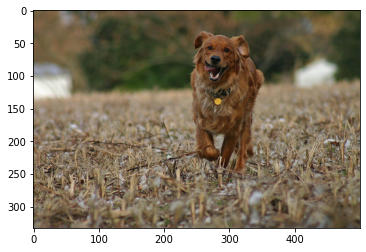

In [29]:
generate_caption(f'{test[150]}.jpg')

Captions: 
startseq dog is running through the water endseq


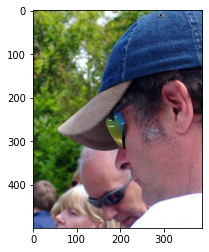

In [30]:
generate_caption(f'{test[200]}.jpg')

Captions: 
startseq two dogs are playing in the snow endseq


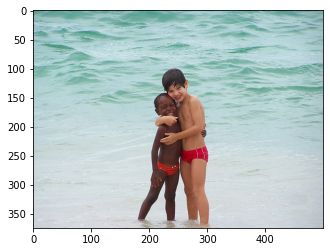

In [31]:
generate_caption(f'{test[250]}.jpg')

Captions: 
startseq man is climbing rocky rocky hill endseq


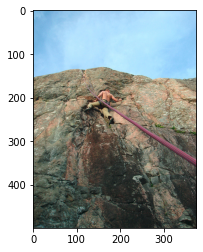

In [32]:
generate_caption(f'{test[300]}.jpg')

Captions: 
startseq man in blue shirt scales rock endseq


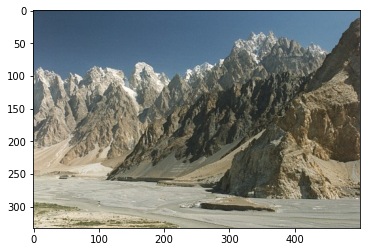

In [33]:
generate_caption(f'{test[350]}.jpg')

Captions: 
startseq man in black shirt and jeans is jumping off quarter handrails endseq


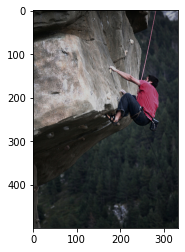

In [34]:
generate_caption(f'{test[399]}.jpg')